In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap
import re

# LOAD DATA

In [11]:
# Load data downloaded from kaggle.
calendar = pd.read_csv("./archive/calendar.csv")
listings = pd.read_csv("./archive/listings.csv")
reviews = pd.read_csv("./archive/reviews.csv")

# INITIAL QUESTIONS
I'm going to use just the CALENDAR and LISTINGS dataset to this project.
- When is more expensive?
- Which characteristics directly affects to the price of the airbnb?
- Is there any zipcode or region more expensive?

# DATA UNDERSTANDING

CALENDAR: Dataset with availability of the airbnbs and their prices.

In [12]:
# Visualization of calendar.csv
calendar.head(2)

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00


LISTINGS: Dataset with all the listed airbnbs and their characteristics.

In [13]:
# Visualization of listings.csv
listings.head(2)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48


REVIEWS: Dataset with clients' reviews. I won't use it.

In [14]:
# Visualization of reviews.csv
reviews.head(2)

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...


# DATA PREPARATION

## Feaure selection
There is to much columns on listings.csv.  
I will select a few interesting columns of LISTINGS dataset due to my experience to reduce the complexity.

In [15]:
# Selection of target columns for listings dataset.
listings = listings[["id","zipcode", "host_listings_count", "latitude", "longitude", 
                    "bathrooms", "bedrooms", "beds", "bed_type", "amenities", "property_type", "room_type",
                    "square_feet", "guests_included", "extra_people", "minimum_nights", "number_of_reviews", 
                    "review_scores_rating", "reviews_per_month", "review_scores_cleanliness", "review_scores_communication", "review_scores_location",
                    "review_scores_value", "instant_bookable", "cancellation_policy", "require_guest_phone_verification",
                    "price", "weekly_price", "monthly_price"]].copy()

## Shapes

In [16]:
# Dimension of datasets.
shape_cal = calendar.shape
shape_list = listings.shape

print(f"Dataset dimensions \n Calendar: {shape_cal} \n Listings: {shape_list}")

Dataset dimensions 
 Calendar: (1393570, 4) 
 Listings: (3818, 29)


## Dataframe Types

In [17]:
def price_to_float(s: str) -> float:
    """Function to format price column.

    :params str s: Price on str type.
    :return float price: Price on float type
    """
    s = str(s)
    price = float(re.sub(r'[\$,]', '', s)) # Replace $ and float type.
    return price

In [19]:
# Format type of calendar dataset.
calendar["date"] = pd.to_datetime(calendar["date"]) # Date to datetime type..
calendar["month"] = calendar["date"].dt.month # Month column
calendar["year"] = calendar["date"].dt.year # Year columns
calendar["price"] = calendar["price"].apply(price_to_float) # Price to flaot.

# Format type of listings dataset.
listings['price'] = listings['price'].apply(price_to_float) # Price to float.

## Nan

### Calendar NaNs

In [20]:
# Nans on calendar dataframe
calendar[calendar.price.isna()]["available"].value_counts()

available
f    459028
Name: count, dtype: int64

Column "price" is NaN when the airbnb is not available.
- Fill with most near value of price for the same ID.
- It is the best method to have the value most similar to what the real one should be.
- Another approach would be to fill in the average between the day before and after for an ID. I decide that it is easier to take the value from the previous day since applying the average will not have a substantial improvement.

In [21]:
# Order by id and date.
calendar.sort_values(by=['listing_id', 'date'], inplace=True)

# Multiindex dataframe to grupby id.
multi_indexed_df = calendar.set_index(['listing_id', 'date'])

# Fill with the nearest value of the same id.
multi_indexed_df['price'] = multi_indexed_df['price'].groupby(level=0).ffill().bfill()
calendar['price'] = multi_indexed_df.reset_index()["price"]

In [22]:
# Check that nans no longer exist
calendar.isna().sum()

listing_id    0
date          0
available     0
price         0
month         0
year          0
dtype: int64

### Listings NaNs

In [23]:
# We check total NaNs
listings_nan = listings.isnull().sum()
listings_nan[listings_nan > 0].sort_values(ascending=False)

square_feet                    3721
monthly_price                  2301
weekly_price                   1809
review_scores_value             656
review_scores_location          655
review_scores_cleanliness       653
review_scores_communication     651
review_scores_rating            647
reviews_per_month               627
bathrooms                        16
zipcode                           7
bedrooms                          6
host_listings_count               2
beds                              1
property_type                     1
dtype: int64

There are to many nans. Various transformations will be applied:
- Drop "square_feet", "monthly_price", "weekly_price" columns. Those columns have to many nans. The quality of the data in these columns is very bad and it was decided to eliminate it.
- The rows where a nan exists for the rest of the variables are droped. It is not considered appropriate to fill the data as it would be unrealistic.
- Due to the large volume of data, these rows can be deleted without greatly reducing the amount of data.

In [24]:
# Drop Columns
listings = listings.drop(columns=["square_feet", "monthly_price", "weekly_price"])

# I will delete rows with nan data.
listings = listings.dropna()

In [25]:
# Check that nans no longer exist
listings.isna().sum()

id                                  0
zipcode                             0
host_listings_count                 0
latitude                            0
longitude                           0
bathrooms                           0
bedrooms                            0
beds                                0
bed_type                            0
amenities                           0
property_type                       0
room_type                           0
guests_included                     0
extra_people                        0
minimum_nights                      0
number_of_reviews                   0
review_scores_rating                0
reviews_per_month                   0
review_scores_cleanliness           0
review_scores_communication         0
review_scores_location              0
review_scores_value                 0
instant_bookable                    0
cancellation_policy                 0
require_guest_phone_verification    0
price                               0
dtype: int64

# Analisis

## When is the Airbnb more expensive?

In [26]:
# Dataframe group by month and apply mean price.
price_month = calendar.groupby(['month'])['price'].mean().to_frame()

<Figure size 1200x600 with 0 Axes>

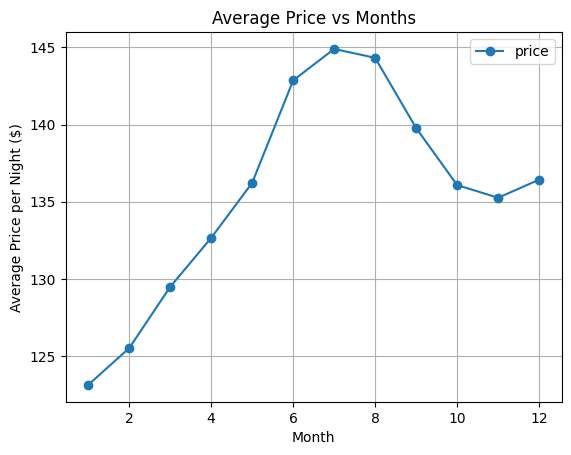

In [27]:
# Matplotlib figure to represent the mean price by month.
plt.figure(figsize=(12,6))
price_month.plot(marker='o')
plt.title('Average Price vs Months')
plt.xlabel('Month')
plt.ylabel('Average Price per Night ($)')
plt.grid(True)
plt.show()

- We can observe that the most expensive price is on summer. June, July and August are the most expensive months.  
- Christmas is the second most expensive season but the prices are reduce by half than on summer.  
- January and February are the cheapest months.

## Which characteristics directly affects to the price of the airbnb?

In [28]:
# Correlations.
list_corr = list.select_dtypes(float).corr() # Select float columns

# Mask to not repeat correlactions.
sns.set(style="white")
mask = np.triu(np.ones_like(list_corr, dtype=bool))

# Seaborn figure
plt.figure(figsize=(10, 8))
sns.heatmap(list_corr, mask=mask, cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5)
plt.show()

AttributeError: type object 'list' has no attribute 'select_dtypes'

We can observe that the number ot bedrooms, bathrooms and beds are the factors that determine more directly the price of the airbnb. At first it may seem that the reviews will affect the price, but it is observed that both variables are not correlated.

## Is there any zipcode or region more expensive?

In [29]:
# Columns to determine the position on the map.
map_list = listings[["latitude", "longitude", "price"]]

In [30]:
# Initialize Map instance.
mapa = folium.Map(location=[map_list['latitude'].mean(), map_list['longitude'].mean()], zoom_start=10)

# Color map.
heat_data = [[row['latitude'], row['longitude'], row['price']] for index, row in map_list.iterrows()]

# Add to map.
HeatMap(heat_data, max_opacity=0.6, radius=9, blur=12).add_to(mapa)

# Show map.
mapa

It can be seen that the most expensive area is the one near downtown Seattle. To be more specific, the most expensive neighborhood is Belltown. There are streets like Hubbel Place with a fairly high price, as well as in the Union Street Substation area.